# **차량 상태 확인하는 다중 분류 모델 만들기**
 - 1차 목표 : 다중 분류 
 - 2차 목표 : [0번 확률, 1번 확률, 2번 확률, 3번 확률, 4번 확률] 로 보여주기  

- 개발 환경 
    - OS : Ubuntu 24.04 LTS

    - GCP VM Instance 

    - Python 3.10.14

    - RAM : e2-standard-16 60GB

    - DISK : 500GB

### python 3.10 가상 환경 생성 
    - python3.10 -m venv ./.venv

  ### ~/car_image_classification에서 pip install -r ./requirements.txt를 한다.
      - 라이브러리가 담겨진 의존성 파일을 설치한다. 

### 사용할 라이브러리를 모두 불러온다.

In [1]:
import zipfile, os, random, shutil, glob, yaml, json
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

2024-08-29 23:26:05.649435: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 23:26:05.877818: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 23:26:06.120865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 23:26:06.307082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 23:26:06.359773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 23:26:06.728749: I tensorflow/core/platform/cpu_feature_gu

## 1. 차량의 상태에 따라 normal(정상), scratch(스크래치), crushed(찌그러짐), breakage(파손), seperated(이격) 폴더에 파일을 저장한다. 

- 정상 차량 데이터를 normal(정상) 폴더로 모은다. 

In [2]:
def copy_images(src_dir,
                dest_dir):
    
    # 목적지 디렉토리가 없으면 생성
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    # 소스 디렉토리의 모든 파일에 대해
    for filename in os.listdir(src_dir):
        # 이미지 파일인지 확인 (여기서는 .jpg와 .png만 고려)
        if filename.lower().endswith(('.png', '.jpg')):
            src_file = os.path.join(src_dir, filename)
            dest_file = os.path.join(dest_dir, filename)
            
            # 파일 복사
            shutil.copy2(src_file, dest_file)
            print(f"Copied: {filename}")

In [3]:
# 소스 및 목적지 디렉토리 경로 설정
src_directory = "./original_source/KT_MiniProject_Car_Data/normal"
dest_directory = "./car_condition/normal"

# 함수 실행
copy_images(src_dir=src_directory,
            dest_dir=dest_directory)

print("All image files have been copied.")

Copied: DALL·E 2023-03-10 23.37.25 - photo of a part of car without blemish.png
Copied: DALL·E 2023-03-10 23.49.38 - a part of car without blemish.png
Copied: DALL·E 2023-03-11 01.01.49 - photo of a part of car.png
Copied: DALL·E 2023-03-11 14.32.34 - part of a car.png
Copied: DALL·E 2023-03-11 14.26.52 - part of a car.png
Copied: DALL·E 2023-03-10 23.40.56 - photo of a part of car without blemish.png
Copied: DALL·E 2023-03-11 01.20.44 - a part of a car.png
Copied: DALL·E 2023-03-11 14.13.06 - part of a car.png
Copied: DALL·E 2023-03-11 14.32.01 - part of a car.png
Copied: DALL·E 2023-03-11 01.35.30 - photo of a car.png
Copied: DALL·E 2023-03-11 14.24.54 - part of a car.png
Copied: DALL·E 2023-03-10 22.24.15 - photo of a part of car.png
Copied: DALL·E 2023-03-11 00.04.36 - a part of car without blemish.png
Copied: DALL·E 2023-03-11 14.12.34 - part of a car.png
Copied: DALL·E 2023-03-10 18.52.44 - photo of a part of car.png
Copied: DALL·E 2023-03-11 14.22.54 - part of a car.png
Copied: 

- original_source/KT_MiniProject_Car_Data/abnormal에 있는 폴더에 있는 파일 제목을 통해<br> scratch(스크래치), crushed(찌그러짐), breakage(파손), seperated(이격) 폴더에 파일을 저장한다.

    -  파일 제목에 scratch, blemish가 나온다? -> scratch(스크래치) 폴더에 저장
    -  파일 제목에 dent가 나온다? -> crushed(찌그러짐) 폴더에 저장 
    -  파일 제목에 dagmage가 나온다? -> breakage(파손) 폴더에 저장 
    -  나머지 -> scratch(스크래치) 폴더에 저장 

    - 이격이 없는 이유는 이격이라 보여지는 차량 사진 데이터가 없었기 떄문 

In [4]:
def copy_images(source_dir,
                scratch_folder,
                breakage_folder,
                crushed_folder):
    
    # 목적지 디렉토리가 없으면 생성
    if not os.path.exists(scratch_folder):
        os.makedirs(scratch_folder)
    if not os.path.exists(breakage_folder):
        os.makedirs(breakage_folder)
    if not os.path.exists(crushed_folder):
        os.makedirs(crushed_folder)

    # 파일이 있는 디렉토리에서 모든 파일을 순회
    for filename in os.listdir(source_dir): 
        # 파일 이름에 따라 대상 폴더 결정
        if 'scratched' in filename or 'blemish' in filename:
            target_folder = scratch_folder
        elif 'damaged' in filename:
            target_folder = breakage_folder
        elif 'dents' in filename or 'dented' in filename:
            target_folder = crushed_folder
        else:
            target_folder = scratch_folder

        # 대상 폴더로 파일 복사
        file_path = os.path.join(source_dir, filename)
        shutil.copy(file_path, target_folder)
        
        print(f'File {filename} copied to {target_folder}')

In [5]:
# 파일이 있는 폴더 경로
source_dir = './original_source/KT_MiniProject_Car_Data/abnormal'  

# 파일이 이동될 폴더 경로들
scratch_folder = './car_condition/scratch'
breakage_folder = './car_condition/breakage'
crushed_folder = './car_condition/crushed'

# 함수 실행
copy_images(source_dir=source_dir,
            scratch_folder=scratch_folder,
            breakage_folder=breakage_folder,
            crushed_folder=crushed_folder)

print("All image files have been copied.")

File DALL·E 2023-03-11 17.27.04 - slightly dented car.png copied to ./car_condition/crushed
File DALL·E 2023-03-11 18.46.24 - scratched car.png copied to ./car_condition/scratch
File DALL·E 2023-03-11 17.28.33 - slightly dented car.png copied to ./car_condition/crushed
File DALL·E 2023-03-11 18.42.59 - slightly dented car.png copied to ./car_condition/crushed
File DALL·E 2023-03-11 15.01.57 - dents of a car.png copied to ./car_condition/crushed
File DALL·E 2023-03-11 14.58.40 - dents of a car.png copied to ./car_condition/crushed
File DALL·E 2023-03-11 18.44.11 - slightly dented car.png copied to ./car_condition/crushed
File DALL·E 2023-03-11 17.31.41 - slightly dented car.png copied to ./car_condition/crushed
File DALL·E 2023-03-10 22.04.39 - scratched car.png copied to ./car_condition/scratch
File DALL·E 2023-03-11 17.25.10 - slightly dented car.png copied to ./car_condition/crushed
File DALL·E 2023-03-11 14.52.54 - dents of a car.png copied to ./car_condition/crushed
File DALL·E 202

- car_condition/original_source/AI_Hub_Car_Problem_Data에 있는 폴더에 있는 원천 데이터와 그에 짝꿍인 라벨링 데이터를 활용하여 <br> scratch(스크래치), crushed(찌그러짐), breakage(파손), seperated(이격) 폴더에 파일을 저장한다.

    -  라벨링 데이터를 의미하는 json 파일에 Breakage 단어가 등장하면? -> breakage(파손) 폴더에 저장
    -  라벨링 데이터를 의미하는 json 파일에 Scratched 단어가 등장하면? -> scratched(스크래치) 폴더에 저장
    -  라벨링 데이터를 의미하는 json 파일에 Crushed 단어가 등장하면? -> crushed(찌그러짐) 폴더에 저장
    -  라벨링 데이터를 의미하는 json 파일에 Separated 단어가 등장하면? -> separated(이격) 폴더에 저장

In [6]:
def copy_images(source_dir,
                scratch_folder,
                breakage_folder,
                crushed_folder,
                separated_folder):
    
    # 목적지 디렉토리가 없으면 생성
    if not os.path.exists(scratch_folder):
        os.makedirs(scratch_folder)
    if not os.path.exists(breakage_folder):
        os.makedirs(breakage_folder)
    if not os.path.exists(crushed_folder):
        os.makedirs(crushed_folder)
    if not os.path.exists(separated_folder):
        os.makedirs(separated_folder)

    # 파일이 있는 디렉토리에서 모든 파일을 순회
    for filename in os.listdir(source_dir): 
        # ex) test.jpg이면 .jpg를 뺴버리고 test.json으로 갈아타버리기 
        json_filename = './original_source/AI_Hub_Car_Problem_Data/라벨링데이터/TL_damage/damage/' \
                            + os.path.splitext(filename)[0] + '.json'
                            
        # JSON 파일 읽기
        with open(json_filename, 'r') as file:
            data = json.load(file)
            
            # 'damgae' 속성이 어떤 것인지 확인
            if data["annotations"][0]["damage"] == 'Scratched':
                target_folder = scratch_folder
            elif data["annotations"][0]["damage"] == 'Breakage':
                target_folder = breakage_folder
            elif data["annotations"][0]["damage"] == 'Crushed':
                target_folder = crushed_folder
            elif data["annotations"][0]["damage"] == 'Separated':
                target_folder = separated_folder
                            
            # 대상 폴더로 파일 복사
            file_path = os.path.join(source_dir, filename)
            shutil.copy(file_path, target_folder)
            
            print(f'File {filename} copied to {target_folder}')

In [7]:
# 파일이 있는 폴더 경로
source_dir = './original_source/AI_Hub_Car_Problem_Data/원천데이터/TS_damage/damage'  

# 파일이 이동될 폴더 경로들
scratch_folder = './car_condition/scratch'
breakage_folder = './car_condition/breakage'
crushed_folder = './car_condition/crushed'
separated_folder = './car_condition/separated'

# 함수 실행
copy_images(source_dir=source_dir,
            scratch_folder=scratch_folder,
            breakage_folder=breakage_folder,
            crushed_folder=crushed_folder,
            separated_folder=separated_folder)

print("All image files have been copied.")

File 0485664_as-0098185.jpg copied to ./car_condition/scratch
File 0186863_sc-154851.jpg copied to ./car_condition/breakage
File 0011321_sc-211697.jpg copied to ./car_condition/breakage
File 0291533_as-2930904.jpg copied to ./car_condition/scratch
File 0189628_as-0099438.jpg copied to ./car_condition/scratch
File 0278533_as-0097487.jpg copied to ./car_condition/breakage
File 0233246_sc-148790.jpg copied to ./car_condition/scratch
File 0111012_sc-167124.jpg copied to ./car_condition/breakage
File 0018551_sc-227131.jpg copied to ./car_condition/scratch
File 0350046_sc-219032.jpg copied to ./car_condition/scratch
File 0468337_as-0098735.jpg copied to ./car_condition/scratch
File 0006632_sc-170061.jpg copied to ./car_condition/scratch
File 0282644_sc-158575.jpg copied to ./car_condition/scratch
File 0426982_sc-129141.jpg copied to ./car_condition/scratch
File 0364308_sc-128647.jpg copied to ./car_condition/separated
File 0073422_sc-202234.jpg copied to ./car_condition/separated
File 047182

## 2. breakage, crushed, normal, scratch, seperated 폴더에 있는 차량 사진을 탐색한다.
    - 각 폴더에 차량 사진이 몇개인지 
    - 차량 사진 이미지 크기는 어떠한지 확인한다.

In [8]:
# 폴더별 이미지 데이터 갯수 확인
print(f"정상 차량 이미지 데이터는 {len(glob.glob('./car_condition/normal/*'))}장 입니다.")
print(f"스크래치 차량 이미지 데이터는 {len(glob.glob('./car_condition/scratch/*'))}장 입니다.")
print(f"파손 차량 이미지 데이터는 {len(glob.glob('./car_condition/breakage/*'))}장 입니다.")
print(f"찌그러짐 차량 이미지 데이터는 {len(glob.glob('./car_condition/crushed/*'))}장 입니다.")
print(f"이격 차량 이미지 데이터는 {len(glob.glob('./car_condition/separated/*'))}장 입니다.")

정상 차량 이미지 데이터는 302장 입니다.
스크래치 차량 이미지 데이터는 811장 입니다.
파손 차량 이미지 데이터는 270장 입니다.
찌그러짐 차량 이미지 데이터는 264장 입니다.
이격 차량 이미지 데이터는 158장 입니다.


- 데이터 불균형 문제가 있어서 최대한 개수를 균형적으로 맞춰야 모델을 객관적으로 훈련할 수 있는데 그냥 넘어가겠습니다....

In [9]:
def show_image(image_path,
               condition):
    
    image_files = glob.glob(image_path)
    rand_n = random.randint(0, len(image_files)-1)
    
    # 선택된 이미지 파일 경로
    selected_image_path = image_files[rand_n]

    # 파일 확장자를 추출한다. 
    file_extension = os.path.splitext(selected_image_path)[-1].lower()

    plt.figure(figsize=(8,8))
    img = plt.imread(image_files[rand_n])
    plt.imshow(img)
    plt.show()

    print(f"{condition} 이미지 데이터의 확장자는 {file_extension} 입니다.")
    print(f"이미지 경로는 {selected_image_path} 입니다.")
    print(f'{condition} 이미지 데이터의 형태는 다음과 같습니다 : {img.shape}')
    print()

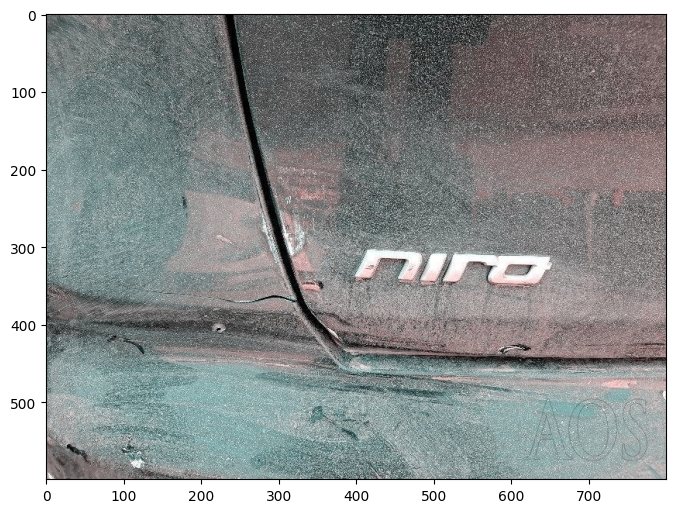

파손 이미지 데이터의 확장자는 .jpg 입니다.
이미지 경로는 ./car_condition/breakage/0413509_as-2547434.jpg 입니다.
파손 이미지 데이터의 형태는 다음과 같습니다 : (600, 800, 3)



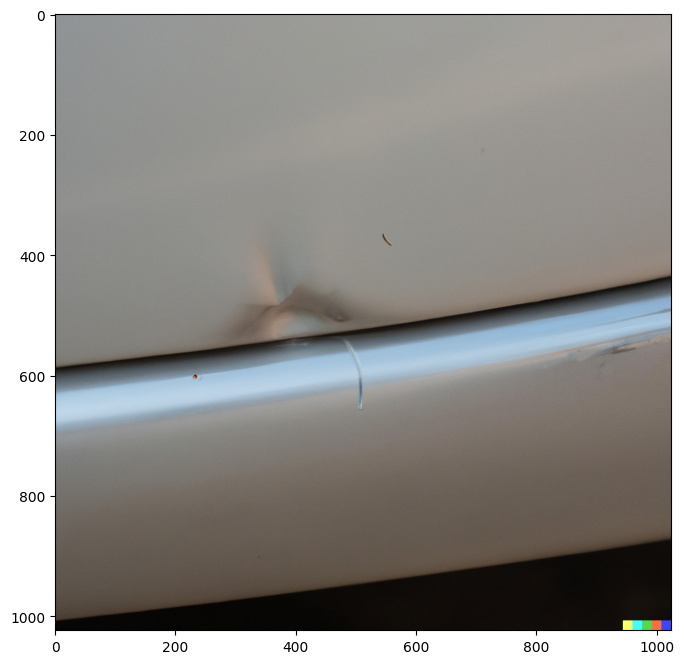

찌그러짐 이미지 데이터의 확장자는 .png 입니다.
이미지 경로는 ./car_condition/crushed/DALL·E 2023-03-11 15.12.28 - dents of a car.png 입니다.
찌그러짐 이미지 데이터의 형태는 다음과 같습니다 : (1024, 1024, 3)



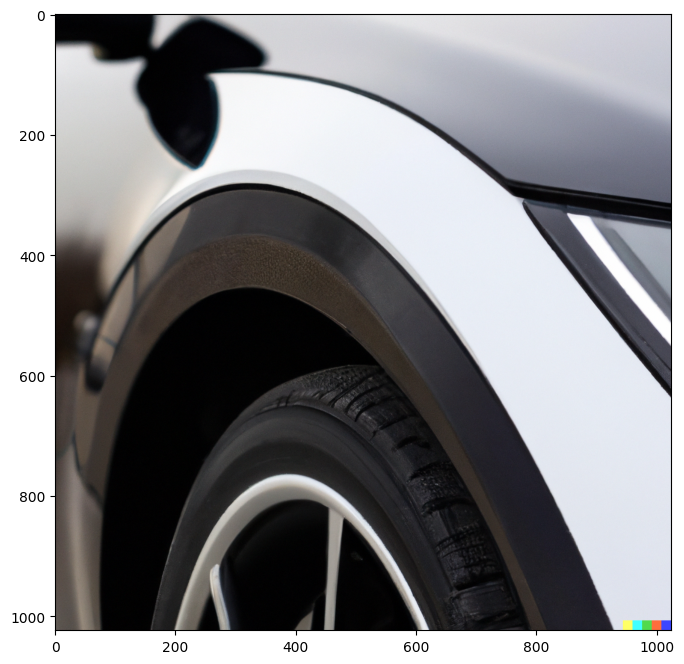

정상 이미지 데이터의 확장자는 .png 입니다.
이미지 경로는 ./car_condition/normal/DALL·E 2023-03-10 18.50.29 - photo of a part of car.png 입니다.
정상 이미지 데이터의 형태는 다음과 같습니다 : (1024, 1024, 3)



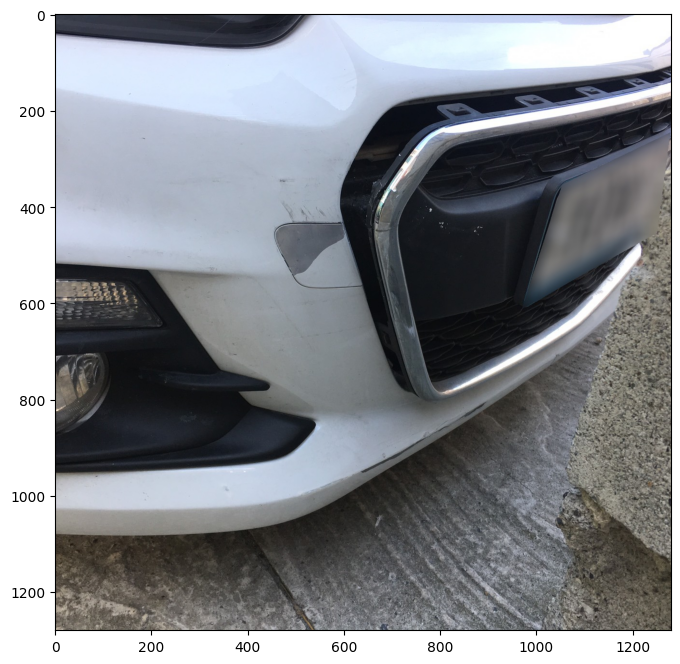

스크래치 이미지 데이터의 확장자는 .jpg 입니다.
이미지 경로는 ./car_condition/scratch/0504606_sc-103986.jpg 입니다.
스크래치 이미지 데이터의 형태는 다음과 같습니다 : (1280, 1280, 3)



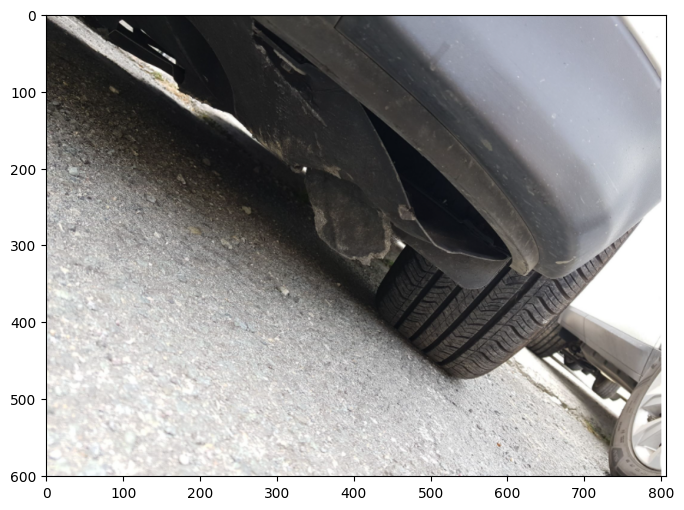

이격 이미지 데이터의 확장자는 .jpg 입니다.
이미지 경로는 ./car_condition/separated/0252005_sc-227856.jpg 입니다.
이격 이미지 데이터의 형태는 다음과 같습니다 : (601, 807, 4)



In [10]:
show_image(image_path="./car_condition/breakage/*",
           condition="파손")

show_image(image_path="./car_condition/crushed/*",
           condition="찌그러짐")

show_image(image_path="./car_condition/normal/*",
           condition="정상")

show_image(image_path="./car_condition/scratch/*",
           condition="스크래치")

show_image(image_path="./car_condition/separated/*",
           condition="이격")

## 3.모델링에 필요한 데이터 전처리를 한다. 

### (1) 모델링용 전처리
* 모델링을 위한 데이터 구조 만들기
    * X : 이미지를 array로 변환합니다.
    * Y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.

#### 1) Y : 클래스 만들기
    - normal(정상) -> 0
    - scratch(스크래치) -> 1
    - crushed(찌그러짐) -> 2
    - breakage(파손) -> 3
    - separated(이격) -> 4로 약속 그리고 라벨링 주기 

In [11]:
# 정상 차량 302장 입니다.
# 스크래치 차량 이미지 데이터는 811장 입니다.
# 찌그러짐 차량 이미지 데이터는 264장 입니다.
# 파손 차량 이미지 데이터는 270장 입니다.
# 이격 차량 이미지 데이터는 158장 입니다

output = [0] * 302 + [1] * 811 + [2] * 264 + [3] * 270 + [4] * 158

In [14]:
output

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


#### 2) X : 데이터 리스트 통합
    - 전체 이미지 데이터를 하나의 리스트로 통합합니다.

In [12]:
# 정상 차량 이미지들
normal_images = os.listdir('./car_condition/normal') 
scratch_images = os.listdir('./car_condition/scratch')
crushed_images = os.listdir('./car_condition/crushed')
breakage_images = os.listdir('./car_condition/breakage')
separated_images = os.listdir('./car_condition/separated') # 정상 차량 이미지들

# 가져온 이미지 파일 리스트 출력
print(normal_images) 
print()
print(scratch_images)
print() 
print(crushed_images)
print() 
print(breakage_images)
print() 
print(separated_images) 

['DALL·E 2023-03-10 23.37.25 - photo of a part of car without blemish.png', 'DALL·E 2023-03-10 23.49.38 - a part of car without blemish.png', 'DALL·E 2023-03-11 01.01.49 - photo of a part of car.png', 'DALL·E 2023-03-11 14.32.34 - part of a car.png', 'DALL·E 2023-03-11 14.26.52 - part of a car.png', 'DALL·E 2023-03-10 23.40.56 - photo of a part of car without blemish.png', 'DALL·E 2023-03-11 01.20.44 - a part of a car.png', 'DALL·E 2023-03-11 14.13.06 - part of a car.png', 'DALL·E 2023-03-11 14.32.01 - part of a car.png', 'DALL·E 2023-03-11 01.35.30 - photo of a car.png', 'DALL·E 2023-03-11 14.24.54 - part of a car.png', 'DALL·E 2023-03-10 22.24.15 - photo of a part of car.png', 'DALL·E 2023-03-11 00.04.36 - a part of car without blemish.png', 'DALL·E 2023-03-11 14.12.34 - part of a car.png', 'DALL·E 2023-03-10 18.52.44 - photo of a part of car.png', 'DALL·E 2023-03-11 14.22.54 - part of a car.png', 'DALL·E 2023-03-11 00.22.47 - photo of a part of car without blemish.png', 'DALL·E 2023

In [14]:
# 정상 차량 이미지 + 스크래치 차량 이미지 + 찌그러짐 차량 이미지 + 파손 차량 이미지 + 이격 차량 이미지를 하나의 리스트로 모은다. 
car_images = normal_images +\
             scratch_images + \
             crushed_images + \
             breakage_images + \
             separated_images 

print(f"하나의 리스트로 모여진 데이터 : {car_images}")
print(f"차량 이미지 총 개수 : {len(car_images)}")

하나의 리스트로 모여진 데이터 : ['DALL·E 2023-03-10 23.37.25 - photo of a part of car without blemish.png', 'DALL·E 2023-03-10 23.49.38 - a part of car without blemish.png', 'DALL·E 2023-03-11 01.01.49 - photo of a part of car.png', 'DALL·E 2023-03-11 14.32.34 - part of a car.png', 'DALL·E 2023-03-11 14.26.52 - part of a car.png', 'DALL·E 2023-03-10 23.40.56 - photo of a part of car without blemish.png', 'DALL·E 2023-03-11 01.20.44 - a part of a car.png', 'DALL·E 2023-03-11 14.13.06 - part of a car.png', 'DALL·E 2023-03-11 14.32.01 - part of a car.png', 'DALL·E 2023-03-11 01.35.30 - photo of a car.png', 'DALL·E 2023-03-11 14.24.54 - part of a car.png', 'DALL·E 2023-03-10 22.24.15 - photo of a part of car.png', 'DALL·E 2023-03-11 00.04.36 - a part of car without blemish.png', 'DALL·E 2023-03-11 14.12.34 - part of a car.png', 'DALL·E 2023-03-10 18.52.44 - photo of a part of car.png', 'DALL·E 2023-03-11 14.22.54 - part of a car.png', 'DALL·E 2023-03-11 00.22.47 - photo of a part of car without blemish

#### 3) 데이터 프레임으로 통합 

In [15]:
# 데이터프레임 생성
df = pd.DataFrame({'car_images': car_images, 
                   'output': output})

In [16]:
df.head()

,car_images,output
0,DALL·E 2023-03-10 23.37.25 - photo of a part o...,0
1,DALL·E 2023-03-10 23.49.38 - a part of car wit...,0
2,DALL·E 2023-03-11 01.01.49 - photo of a part o...,0
3,DALL·E 2023-03-11 14.32.34 - part of a car.png,0
4,DALL·E 2023-03-11 14.26.52 - part of a car.png,0


In [19]:
df.tail()

,car_images,output
1800,0411417_as-0098018.jpg,4
1801,0236550_as-2596435.jpg,4
1802,0001061_sc-123724.jpg,4
1803,0450689_as-9068922.jpg,4
1804,0129728_sc-130028.jpg,4


In [17]:
df["output"].value_counts(ascending=False)

output
1    811
0    302
3    270
2    264
4    158
Name: count, dtype: int64

#### 4) 데이터셋 분리
- 데이터 스플릿의 비율은 train set : validation set : test set = 8 : 1: 1 로 설정하세요.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# 전체 데이터를 80% train set, 20% (test set + validation set)로 분리
train_df, test_val_df = train_test_split(df, 
                                         test_size=0.2,
                                         stratify=df["output"],
                                         random_state=42)

# (test set + validation set)를 test set과 validation set으로 분리 (각각 50%)
test_df, val_df = train_test_split(test_val_df, 
                                   test_size=0.5,
                                   stratify=test_val_df["output"],
                                   random_state=42)

In [20]:
train_df.shape, val_df.shape, test_df.shape

((1444, 2), (181, 2), (180, 2))

* train_test_split을 활용했기 떄문에 데이터프레임 인덱스가 불규칙적으로 번호가 배치될 것이다. 따라서 0부터 연속적인 정수로 부여한다.

In [21]:
# 인덱스를 0부터 시작하는 연속적인 정수로 재설정
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

#### 5) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다.
    * 이미지 파일을 불러와 Training data, Validation data, Test data 각각 array 형태로 변환해 봅시다.
        * 각 폴더로 부터 이미지 목록을 만들고
        * 이미지 한장씩 적절한 크기로 로딩하여 (keras.utils.load_img)
            * 이미지가 너무 크면 학습시간이 많이 걸리고, 메모리 부족현상이 발생될 수 있습니다.
            * 이미지 크기를 280 * 280 * 3 이내의 크기를 설정하여 로딩하시오.
            * array로 변환 (keras.utils.img_to_array, np.expand_dims)
        * 데이터셋에 추가합니다.(데이터셋도 array)

* train_df의 car_images 열에 있는 차량 파일을 불러와서 이미지 크기를 (280 * 280 * 3)으로 설정하고 np.array 형태로 만든다.
* val_df의 car_images 열에 있는 차량 파일을 불러와서 이미지 크기를 (280 * 280 * 3)으로 설정하고 np.array 형태로 만든다.
* test_df의 car_images 열에 있는 차량 파일을 불러와서 이미지 크기를 (280 * 280 * 3)으로 설정하고 np.array 형태로 만든다.

In [26]:
from keras.preprocessing.image import load_img, img_to_array

# 데이터프레임 내의 이미지 파일을 NumPy 배열로 변환하는 함수 
def image_to_array(image_file_names,
                   output):
   
   # 각 이미지를 NumPy 배열로 변환
   image_arrays = []

   for ifn, output in zip(image_file_names, output):
      # 정상 차량 이미지인 경우
      if output == 0: 
         # target_size를 (280, 280)만 줘도 된다고 한다. 
         # load_img 함수는 기본적으로 이미지를 RGB 형식으로 로드하므로 채널의 크기는 3이 된다. 
         img = load_img(f'./car_condition/normal/{ifn}',
                        target_size=(280, 280)) 
      # 스크래치 이미지인 경우 
      elif output == 1:
         # target_size를 (280, 280)만 줘도 된다고 한다. 
         # load_img 함수는 기본적으로 이미지를 RGB 형식으로 로드하므로 채널의 크기는 3이 된다. 
         img = load_img(f'./car_condition/scratch/{ifn}',
                        target_size=(280, 280)) 
      # 찌그러짐 이미지인 경우 
      elif output == 2:
         # target_size를 (280, 280)만 줘도 된다고 한다. 
         # load_img 함수는 기본적으로 이미지를 RGB 형식으로 로드하므로 채널의 크기는 3이 된다. 
         img = load_img(f'./car_condition/crushed/{ifn}',
                        target_size=(280, 280)) 
      # 파손 이미지인 경우 
      elif output == 3:
         # target_size를 (280, 280)만 줘도 된다고 한다. 
         # load_img 함수는 기본적으로 이미지를 RGB 형식으로 로드하므로 채널의 크기는 3이 된다. 
         img = load_img(f'./car_condition/breakage/{ifn}',
                        target_size=(280, 280)) 
      # 이격 이미지인 경우 
      elif output == 4:
         # target_size를 (280, 280)만 줘도 된다고 한다. 
         # load_img 함수는 기본적으로 이미지를 RGB 형식으로 로드하므로 채널의 크기는 3이 된다. 
         img = load_img(f'./car_condition/separated/{ifn}',
                        target_size=(280, 280)) 

      img_array = img_to_array(img)
      img_array = np.expand_dims(img_array, 
                                 axis=0)
      image_arrays.append(img_array)

   # 모든 이미지 배열을 하나의 배열로 결합
   return np.concatenate(image_arrays,
                         axis=0)


In [27]:
train_X = image_to_array(image_file_names= train_df['car_images'],
                         output=train_df["output"])

val_X = image_to_array(image_file_names= val_df['car_images'],
                       output=val_df["output"])

test_X = image_to_array(image_file_names= test_df['car_images'],
                       output=test_df["output"])

In [28]:
train_X

array([[[[ 60.,  56.,  53.],
         [107., 102.,  98.],
         [117., 108.,  99.],
         ...,
         [123., 116., 110.],
         [103.,  99.,  96.],
         [102., 102., 102.]],

        [[128., 121., 115.],
         [ 98.,  91.,  83.],
         [ 82.,  73.,  64.],
         ...,
         [109., 102.,  96.],
         [100.,  96.,  93.],
         [102., 102., 102.]],

        [[124., 114., 104.],
         [187., 179., 168.],
         [143., 137., 123.],
         ...,
         [114., 107., 101.],
         [101.,  97.,  94.],
         [ 98.,  98.,  98.]],

        ...,

        [[118., 108.,  99.],
         [111., 101.,  92.],
         [ 89.,  79.,  70.],
         ...,
         [133., 124., 119.],
         [165., 156., 149.],
         [ 75.,  66.,  59.]],

        [[128., 117., 111.],
         [ 72.,  61.,  55.],
         [122., 111., 105.],
         ...,
         [127., 118., 113.],
         [ 91.,  82.,  73.],
         [218., 210., 199.]],

        [[137., 127., 117.],
       

In [29]:
val_X

array([[[[178., 175., 166.],
         [178., 177., 168.],
         [178., 178., 166.],
         ...,
         [162., 161., 156.],
         [161., 160., 155.],
         [161., 160., 155.]],

        [[178., 175., 166.],
         [176., 176., 166.],
         [176., 176., 165.],
         ...,
         [162., 161., 156.],
         [161., 160., 155.],
         [161., 160., 155.]],

        [[177., 174., 165.],
         [176., 176., 166.],
         [177., 177., 166.],
         ...,
         [162., 161., 156.],
         [161., 160., 155.],
         [162., 161., 156.]],

        ...,

        [[188., 182., 168.],
         [186., 180., 164.],
         [187., 181., 165.],
         ...,
         [154., 161., 157.],
         [157., 166., 161.],
         [160., 166., 162.]],

        [[187., 181., 166.],
         [187., 181., 165.],
         [189., 183., 168.],
         ...,
         [158., 166., 162.],
         [154., 165., 160.],
         [161., 169., 166.]],

        [[185., 179., 163.],
       

In [30]:
test_X

array([[[[ 25.,  25.,  25.],
         [ 26.,  26.,  26.],
         [ 27.,  27.,  27.],
         ...,
         [125., 124., 120.],
         [124., 123., 119.],
         [129., 128., 124.]],

        [[ 25.,  25.,  25.],
         [ 26.,  26.,  26.],
         [ 27.,  27.,  27.],
         ...,
         [126., 125., 121.],
         [130., 129., 125.],
         [134., 133., 129.]],

        [[ 25.,  25.,  25.],
         [ 25.,  25.,  25.],
         [ 27.,  27.,  27.],
         ...,
         [135., 134., 130.],
         [139., 138., 134.],
         [140., 139., 135.]],

        ...,

        [[ 86.,  72.,  61.],
         [121., 111., 101.],
         [ 57.,  51.,  39.],
         ...,
         [121., 103.,  91.],
         [195., 179., 166.],
         [204., 188., 175.]],

        [[124., 110., 101.],
         [126., 116., 106.],
         [ 44.,  38.,  26.],
         ...,
         [157., 141., 128.],
         [139., 123., 110.],
         [137., 123., 110.]],

        [[ 75.,  62.,  54.],
       

- train에 있는 차량 사진들이 1444장 존재하고 사진의 이미지 크기는 280 * 280 * 3으로 통일했으며, np.array 형태로 숫자화 하였다. 

In [32]:
train_X.shape

(1444, 280, 280, 3)

- val 에 있는 차량 사진들이 181장 존재하고 사진의 이미지 크기는 280 * 280 * 3으로 통일했으며, np.array 형태로 숫자화 하였다. 

In [33]:
val_X.shape

(181, 280, 280, 3)

- test에 있는 차량 사진들이 180장 존재하고 사진의 이미지 크기는 280 * 280 * 3으로 통일했으며, np.array 형태로 숫자화 하였다. 

In [34]:
test_X.shape

(180, 280, 280, 3)

#### 6) y : 단일 정수 레이블 형태를 5개의 클래스에 대한 원-핫 인코딩 형태로 변환

- label이 0이였으면 1 0 0 0 0 
- label이 1이었으면 0 1 0 0 0 
- label이 2이었으면 0 0 1 0 0
- label이 3이었으면 0 0 0 1 0 
- label이 4이었으면 0 0 0 0 1

In [54]:
from tensorflow.keras.utils import to_categorical

# 훈련 데이터 변환
train_y = to_categorical(train_df["output"], 
                         num_classes=5)

# 검증 데이터 변환
val_y = to_categorical(val_df["output"],
                       num_classes=5)

# 테스트 데이터 변환 
test_y = to_categorical(test_df["output"],
                       num_classes=5)

In [55]:
train_y

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [57]:
val_y

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0.

In [58]:
test_y

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1.

## 3.모델링
- train_X (차량 이미지들이 280 * 280 * 3 크기로 np.array 형태로 저장되어 있는 형태)
- train_y (label이 원핫인코딩 된 형태)

- val_X (차량 이미지들이 280 * 280 * 3 크기로 np.array 형태로 저장되어 있는 형태)
- val_y (label이 원핫인코딩된 형태)

- 얘네들을 가지고 모델을 학습하고 검증까지 시도한다. 

In [59]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report

## 1) Transfer Learning - VGG16
    - VGG16 모델은 1000개의 클래스를 분류하는 데 사용된 ImageNet 데이터셋을 기반으로 사전 학습된 가중치를 가지고 있다.
        - 따라서 이 모델은 이미지 분류 문제에 대한 높은 성능을 보인다.
        -  이 모델은 보통 전이학습(transfer learning)에서 기본적으로 사용되며, 특히 대규모 데이터셋이 없을 때는 기본 모델로 사용되어 fine-tuning을 수행합니다.
    -  VGG16 함수로 부터 base_model 저장


In [60]:
from tensorflow.keras.applications import VGG16

#### 1) VGG16 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드한다. 
* .trainable을 False로 설정하여 모델의 모든 레이어들을 Frozen 시켜 가중치를 고정한다.


In [61]:
# VGG16 모델 불러오기
# include_top=False: 분류기 부분을 제외
# weights='imagenet': ImageNet으로 미리 학습된 가중치 사용
# input_shape: 입력 이미지의 크기를 정의 (옵션)
vgg16 = VGG16(include_top=False,
              weights='imagenet',
              input_shape=(280, 280, 3)) # 우리가 사용하는 이미지가 (280, 280, 3)이여서 그렇다.

# 모든 레이어를 동결하여 가중치가 업데이트되지 않도록 설정
for layer in vgg16.layers:
    layer.trainable = False

# 모델 정보 출력 (옵션)
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 280, 280, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 280, 280, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 280, 280, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 140, 140, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 140, 140, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 140, 140, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 70, 70, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 70, 70, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 70, 70, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 70, 70, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 35, 35, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 35, 35, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 35, 35, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 35, 35, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 17, 17, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 17, 17, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 17, 17, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 17, 17, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

#### 2) VGG16과 연결한 구조 설계
* VGG16을 불러와서 Flatten, Dense 등으로 레이어 연결하기

In [62]:
# 새로운 모델 구조 설계
vgg16_model = Sequential()

# VGG16 모델
vgg16_model.add(vgg16)                              

# Flatten 층 추가
vgg16_model.add(Flatten())                           

# Dense 층 추가
vgg16_model.add(Dense(256,
                      activation='swish'))      

# Dropout 층 추가 (과적합 방지)
vgg16_model.add(Dropout(0.3))                       

# BatchNormalization 층 추가
vgg16_model.add(BatchNormalization())              

# Dense 층 추가
vgg16_model.add(Dense(128, 
                      activation='swish'))     

# Dropout 층 추가 (과적합 방지)
vgg16_model.add(Dropout(0.3))                        

# BatchNormalization 층 추가
vgg16_model.add(BatchNormalization())               

# Dense 층 추가
vgg16_model.add(Dense(64, 
                      activation='swish'))       

# Dropout 층 추가 (과적합 방지)
vgg16_model.add(Dropout(0.3))                       

# BatchNormalization 층 추가
vgg16_model.add(BatchNormalization())         
       
# 출력층 추가 (5개 클래스 분류를 위해 softmax 활성화 함수 사용)
vgg16_model.add(Dense(5,
                      activation='softmax'))      

# 모델 컴파일
vgg16_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

#### 3) 학습

In [64]:
history = vgg16_model.fit(train_X,
                          train_y,
                          epochs=5,
                          batch_size=32,
                          validation_data=(val_X,
                                           val_y),)



Epoch 1/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.9310 - loss: 0.2310 - val_accuracy: 0.7127 - val_loss: 1.0132
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.9231 - loss: 0.2271 - val_accuracy: 0.7238 - val_loss: 1.0146
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.9507 - loss: 0.1575 - val_accuracy: 0.7238 - val_loss: 1.0410
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 0.9572 - loss: 0.1425 - val_accuracy: 0.7348 - val_loss: 0.9881
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.9687 - loss: 0.1153 - val_accuracy: 0.7403 - val_loss: 1.0639


#### 4) 성능 평가

- 테스트 데이터(181개)를 넣어서 각 결과값마다 0에 대한 확률, 1에 대한 확률, 2에 대한 확률, 3에 대한 확률, 4에 대한 확률을 보여준다. 

In [77]:
# 출력 옵션 설정 (소수점 이하 4자리까지만 보여주세요...)
np.set_printoptions(suppress=True,
                    precision=4)


In [89]:
test_X

array([[[[ 25.,  25.,  25.],
         [ 26.,  26.,  26.],
         [ 27.,  27.,  27.],
         ...,
         [125., 124., 120.],
         [124., 123., 119.],
         [129., 128., 124.]],

        [[ 25.,  25.,  25.],
         [ 26.,  26.,  26.],
         [ 27.,  27.,  27.],
         ...,
         [126., 125., 121.],
         [130., 129., 125.],
         [134., 133., 129.]],

        [[ 25.,  25.,  25.],
         [ 25.,  25.,  25.],
         [ 27.,  27.,  27.],
         ...,
         [135., 134., 130.],
         [139., 138., 134.],
         [140., 139., 135.]],

        ...,

        [[ 86.,  72.,  61.],
         [121., 111., 101.],
         [ 57.,  51.,  39.],
         ...,
         [121., 103.,  91.],
         [195., 179., 166.],
         [204., 188., 175.]],

        [[124., 110., 101.],
         [126., 116., 106.],
         [ 44.,  38.,  26.],
         ...,
         [157., 141., 128.],
         [139., 123., 110.],
         [137., 123., 110.]],

        [[ 75.,  62.,  54.],
       

In [78]:
# 테스트 데이터를 넣어서 0에 대한 
y_pred = vgg16_model.predict(test_X) 

y_pred


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step


array([[0.0003, 0.9956, 0.0005, 0.0004, 0.0033],
       [0.0024, 0.9439, 0.0011, 0.0336, 0.019 ],
       [0.0021, 0.9067, 0.0837, 0.005 , 0.0026],
       [0.0977, 0.7885, 0.0196, 0.0654, 0.0288],
       [0.004 , 0.    , 0.9952, 0.0005, 0.0002],
       [0.0283, 0.9585, 0.0044, 0.0018, 0.0071],
       [0.0018, 0.9954, 0.0004, 0.0009, 0.0016],
       [0.0094, 0.0141, 0.9616, 0.0119, 0.003 ],
       [0.0164, 0.9747, 0.002 , 0.0003, 0.0066],
       [0.3032, 0.6653, 0.0163, 0.0038, 0.0113],
       [0.9994, 0.    , 0.0003, 0.0002, 0.    ],
       [0.6553, 0.0459, 0.2655, 0.0259, 0.0074],
       [0.6532, 0.2942, 0.0324, 0.0038, 0.0165],
       [0.9869, 0.0008, 0.01  , 0.0016, 0.0007],
       [0.0121, 0.8039, 0.1633, 0.0092, 0.0115],
       [0.002 , 0.9351, 0.0064, 0.0256, 0.0309],
       [0.0036, 0.9819, 0.0029, 0.0029, 0.0086],
       [0.9999, 0.    , 0.    , 0.    , 0.0001],
       [0.0017, 0.032 , 0.9606, 0.0045, 0.0013],
       [0.0001, 0.0007, 0.0015, 0.9976, 0.0001],
       [0.0026, 0.57

In [79]:
# 결과 출력
print(f"결과값 데이터 개수  : {len(y_pred)}")
print()

print("0, 1, 2, 3, 4에 대한 확률")
print(y_pred)


결과값 데이터 개수  : 180

0, 1, 2, 3, 4에 대한 확률
[[0.0003 0.9956 0.0005 0.0004 0.0033]
 [0.0024 0.9439 0.0011 0.0336 0.019 ]
 [0.0021 0.9067 0.0837 0.005  0.0026]
 [0.0977 0.7885 0.0196 0.0654 0.0288]
 [0.004  0.     0.9952 0.0005 0.0002]
 [0.0283 0.9585 0.0044 0.0018 0.0071]
 [0.0018 0.9954 0.0004 0.0009 0.0016]
 [0.0094 0.0141 0.9616 0.0119 0.003 ]
 [0.0164 0.9747 0.002  0.0003 0.0066]
 [0.3032 0.6653 0.0163 0.0038 0.0113]
 [0.9994 0.     0.0003 0.0002 0.    ]
 [0.6553 0.0459 0.2655 0.0259 0.0074]
 [0.6532 0.2942 0.0324 0.0038 0.0165]
 [0.9869 0.0008 0.01   0.0016 0.0007]
 [0.0121 0.8039 0.1633 0.0092 0.0115]
 [0.002  0.9351 0.0064 0.0256 0.0309]
 [0.0036 0.9819 0.0029 0.0029 0.0086]
 [0.9999 0.     0.     0.     0.0001]
 [0.0017 0.032  0.9606 0.0045 0.0013]
 [0.0001 0.0007 0.0015 0.9976 0.0001]
 [0.0026 0.5799 0.016  0.1646 0.237 ]
 [0.4953 0.0052 0.0876 0.4074 0.0045]
 [0.098  0.0873 0.7813 0.0264 0.007 ]
 [0.001  0.9879 0.0034 0.0017 0.0059]
 [0.0028 0.9924 0.0014 0.0005 0.003 ]
 [0.0006 0

- 평가 지표(ex. 정확도, f1 score)를 프린트하기 위해서 무엇을 해야 하는가? 
  - test_y가 지금 원핫인코딩 된 형태이므로 np.argmax()를 통해 하나의 값으로 치환해야 한다. 


  - test_X에 대한 데이터를 가지고 vgg16_model를 돌려서 나온 예측값 확률 리스트 y_pred를<br>
    0에 대한 확률, 1에 대한 확률, 2에 대한 확률, 3에 대한 확률, 4에 대한 확률 중 가장 큰 확률를 찾아 하나의 값으로 대치한다. 
    - 만약 0에 대한 확률이 가장 크면 0으로 결론 내린다. 


In [94]:
test_y_classes = np.argmax(test_y, 
                           axis=1)

test_y_classes

array([1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 2, 3, 2, 3,
       2, 1, 1, 1, 0, 1, 1, 3, 0, 1, 2, 4, 1, 4, 1, 2, 0, 1, 1, 4, 4, 1,
       3, 3, 3, 0, 1, 0, 3, 0, 1, 0, 1, 0, 1, 2, 1, 1, 3, 1, 4, 2, 4, 2,
       2, 0, 1, 1, 4, 1, 1, 1, 2, 2, 3, 0, 3, 3, 1, 4, 1, 1, 0, 1, 3, 1,
       1, 2, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 4, 2, 1, 2, 3, 3, 1, 3, 4,
       0, 0, 1, 4, 4, 0, 1, 1, 1, 4, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 3, 1,
       3, 1, 1, 0, 1, 1, 3, 3, 1, 2, 1, 1, 4, 4, 1, 1, 1, 3, 2, 3, 3, 0,
       1, 0, 1, 1, 2, 1, 0, 3, 3, 1, 1, 0, 1, 1, 2, 3, 1, 0, 2, 3, 2, 3,
       1, 4, 1, 2])

In [95]:
y_pred_classes = np.argmax(y_pred, 
                           axis=1)

y_pred_classes

array([1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 2, 3, 1, 0,
       2, 1, 1, 1, 0, 1, 1, 3, 0, 1, 2, 1, 1, 4, 1, 2, 0, 1, 1, 1, 1, 1,
       3, 4, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 2, 1, 3, 2, 1, 0,
       1, 0, 1, 1, 3, 1, 0, 1, 2, 2, 3, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 2, 1, 1, 1, 1, 1, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       0, 0, 1, 4, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 0, 1, 3, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 3, 0,
       1, 0, 3, 1, 2, 1, 0, 1, 3, 1, 1, 0, 1, 1, 1, 2, 1, 0, 1, 3, 0, 3,
       1, 1, 3, 2])

In [101]:
# 평가 및 메트릭 계산
accuracy = accuracy_score(y_true=test_y_classes,
                          y_pred=y_pred_classes)

print("Accuracy:", accuracy)

Accuracy: 0.7333333333333333


<h2> 4. 실 사용자가 이미지 하나를 업로드했을 떄 vgg16 model를 거쳐 예측값이 어떻게 나오는지 시나리오 구성 </h2>

- 실 사용자가 차량 사진 하나를 업로드한다고 상황을 가정하자. 
  - 여기 상황에서 ./car_condition/에서 breakage, crushed, normal, scratch, separated 폴더에 있는 차량 사진을 다 가져와서<br>
    거기에서 랜덤으로 1개 가져와서 마치 실 사용자가 차량 사진 하나를 업로드하는 상황을 재현한다. 

In [107]:
import random

# 메인 폴더 경로
main_folder = './car_condition'

# 하위 폴더 목록
subfolders = ['breakage', 
              'crushed',
              'normal',
              'scratch',
              'separated']


# 모든 이미지 파일 경로를 저장할 리스트
all_images = []

# 각 하위 폴더를 순회하며 이미지 파일 경로 수집
for subfolder in subfolders:
    folder_path = os.path.join(main_folder,
                               subfolder)
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg')):  # 이미지 파일 확장자
            all_images.append(os.path.join(folder_path,
                                           filename))

# 랜덤으로 하나의 이미지 선택
if all_images:
    random_image = random.choice(all_images)
    print(f"선택된 이미지: {random_image}")
else:
    print("이미지를 찾을 수 없습니다.")

선택된 이미지: ./car_condition/scratch/DALL·E 2023-03-11 17.18.47 - scratched car.png


- 선택된 이미지를 280 * 280 * 3으로 이미지 크기를 통일시키고 np.array 형태로 숫자화 한다. 

In [108]:
from keras.preprocessing.image import load_img, img_to_array

# 데이터프레임 내의 이미지 파일을 NumPy 배열로 변환하는 함수 
def image_to_array(image_file_names):
   
    # 각 이미지를 NumPy 배열로 변환
    image_arrays = []

    img = load_img(image_file_names,
                  target_size=(280, 280)) 


    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, 
                                axis=0)
    image_arrays.append(img_array)

    # 모든 이미지 배열을 하나의 배열로 결합
    return np.concatenate(image_arrays,
                         axis=0)


In [110]:
test_X = image_to_array(image_file_names= random_image)

In [111]:
test_X

array([[[[220., 227., 235.],
         [224., 233., 236.],
         [226., 233., 241.],
         ...,
         [195., 205., 211.],
         [200., 206., 218.],
         [199., 209., 214.]],

        [[222., 228., 235.],
         [223., 228., 234.],
         [221., 225., 230.],
         ...,
         [199., 210., 215.],
         [198., 207., 216.],
         [196., 206., 212.]],

        [[208., 217., 221.],
         [212., 219., 226.],
         [216., 220., 228.],
         ...,
         [193., 204., 213.],
         [197., 204., 212.],
         [196., 203., 211.]],

        ...,

        [[162., 151., 137.],
         [166., 156., 145.],
         [167., 153., 143.],
         ...,
         [ 60.,  70., 255.],
         [ 60.,  70., 255.],
         [ 60.,  70., 255.]],

        [[165., 155., 141.],
         [170., 157., 142.],
         [168., 158., 147.],
         ...,
         [ 60.,  70., 255.],
         [ 60.,  70., 255.],
         [ 60.,  70., 255.]],

        [[164., 151., 140.],
       

- 실 사용자가 입력한 이미지를 vgg16_model에 넣어서 예측값 확률 리스트를 보여준다. 

In [112]:
# 테스트 데이터를 넣어서 예측값 확률을 보여준다. 
y_pred = vgg16_model.predict(test_X) 

y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


array([[0.0116, 0.9702, 0.0118, 0.0017, 0.0047]], dtype=float32)

- 예를 들어 웹 사이트 화면 상에서 1이 의미는 스크래치 이므로 이를 보여줄 수 있을 것이다. 

In [113]:
y_pred_classes = np.argmax(y_pred, 
                           axis=1)

y_pred_classes

array([1])